In [1]:
# Import data
import pandas as pd

# observations = pd.read_csv('./data/observations.csv')
observations = pd.read_csv('./data/observations2.csv')
results = pd.read_csv('./data/A7_output.csv')


In [2]:
# Additional functions
import math

def calculate_MSPE(pred_mean, obs_mean, pred_std, obs_std, corr_coef) -> float:
    return (pred_mean - obs_mean)**2 + (pred_std - corr_coef*obs_std)**2 + (1-corr_coef**2)*obs_std**2

def calculate_CCC(pred_mean, obs_mean, pred_std, obs_std, corr_coef) -> float:
    u = (pred_mean - obs_mean) / math.sqrt(pred_std * obs_std)
    v = pred_std / obs_std
    Cb = ((v + 1/v + u**2)/2)**-1
    return corr_coef * Cb


In [3]:
# Create model function
import matplotlib.pyplot as plt

def plot_model_output(observations,
                      results):
    
    ### Check column names match ###
    column_names = list(observations.columns)
    column_names.remove('t')
    # Do not plot time (t)
    # MSPE and CCC will be calculated for every flux included in column_names
    for name in column_names:
        if name in list(results.columns):
            pass
        else:
            raise ValueError("Missing the following columns in results:", name)
    
########################
# Generate summary statistics for dataframes
########################
    # Observation Statitics
    obs_means = observations.mean()
    obs_std = observations.std()
    observations_stats = pd.DataFrame({'Mean': obs_means, 'Std Deviation': obs_std})

    # Results Statistics
    results_means = results.mean()
    results_std = results.std()
    results_stats = pd.DataFrame({"Mean": results_means, "Std Deviation": results_std})

    # Pearson Correlation Coefficients
    corr_results = {}
    for name in column_names:
        correlation = observations[name].corr(results[name])
        corr_results[name] = correlation 

########################
# Calculate MSPE
########################
    MSPE_results = {}
    # Calculate MSPE for each observation column
    for name in column_names:
        MSPE = calculate_MSPE(results_stats.loc[name, "Mean"],
                              observations_stats.loc[name, "Mean"], 
                              results_stats.loc[name, "Std Deviation"], 
                              observations_stats.loc[name, "Std Deviation"],
                              corr_results[name])
        MSPE_results[name] = MSPE

########################
# Calculate CCC
########################
    CCC_results = {}
    # Calculate CCC for each observation column
    for name in column_names:
        CCC = calculate_CCC(results_stats.loc[name, "Mean"],
                            observations_stats.loc[name, "Mean"], 
                            results_stats.loc[name, "Std Deviation"], 
                            observations_stats.loc[name, "Std Deviation"],
                            corr_results[name])
        CCC_results[name] = CCC

########################
# Create plot
########################
    # Calculate the number of rows and columns for the grid
    num_plots = len(column_names)
    num_cols = 3  # You can adjust the number of columns as needed
    num_rows = math.ceil(num_plots / num_cols)

    # Create a grid of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axs array if it's a 2D array
    if num_rows > 1:
        axs = axs.flatten()

    # Loop through each column name and create individual scatter plots
    for i, name in enumerate(column_names):
        ax = axs[i]
        ax.scatter(observations[name], results[name], label='Data Points')

        # Add a line with y-intercept of 0 and slope of 1
        ax.axline(xy1=(0, 0), slope=1, color='red', linestyle='--', label='Perfect Prediction (y=x)')

        ax.set_xlabel('Observed Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'Observed vs Predicted - {name}')

        # Annotate with MSPE and CCC values in the bottom left corner
        ax.text(0.7, 0.1, f'MSPE: {MSPE_results[name]:.2f}', transform=ax.transAxes, fontsize=10, color='red')
        ax.text(0.7, 0.05, f'CCC: {CCC_results[name]:.2f}', transform=ax.transAxes, fontsize=10, color='blue')

        # Force x and y axes to start at 0
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

        # ax.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



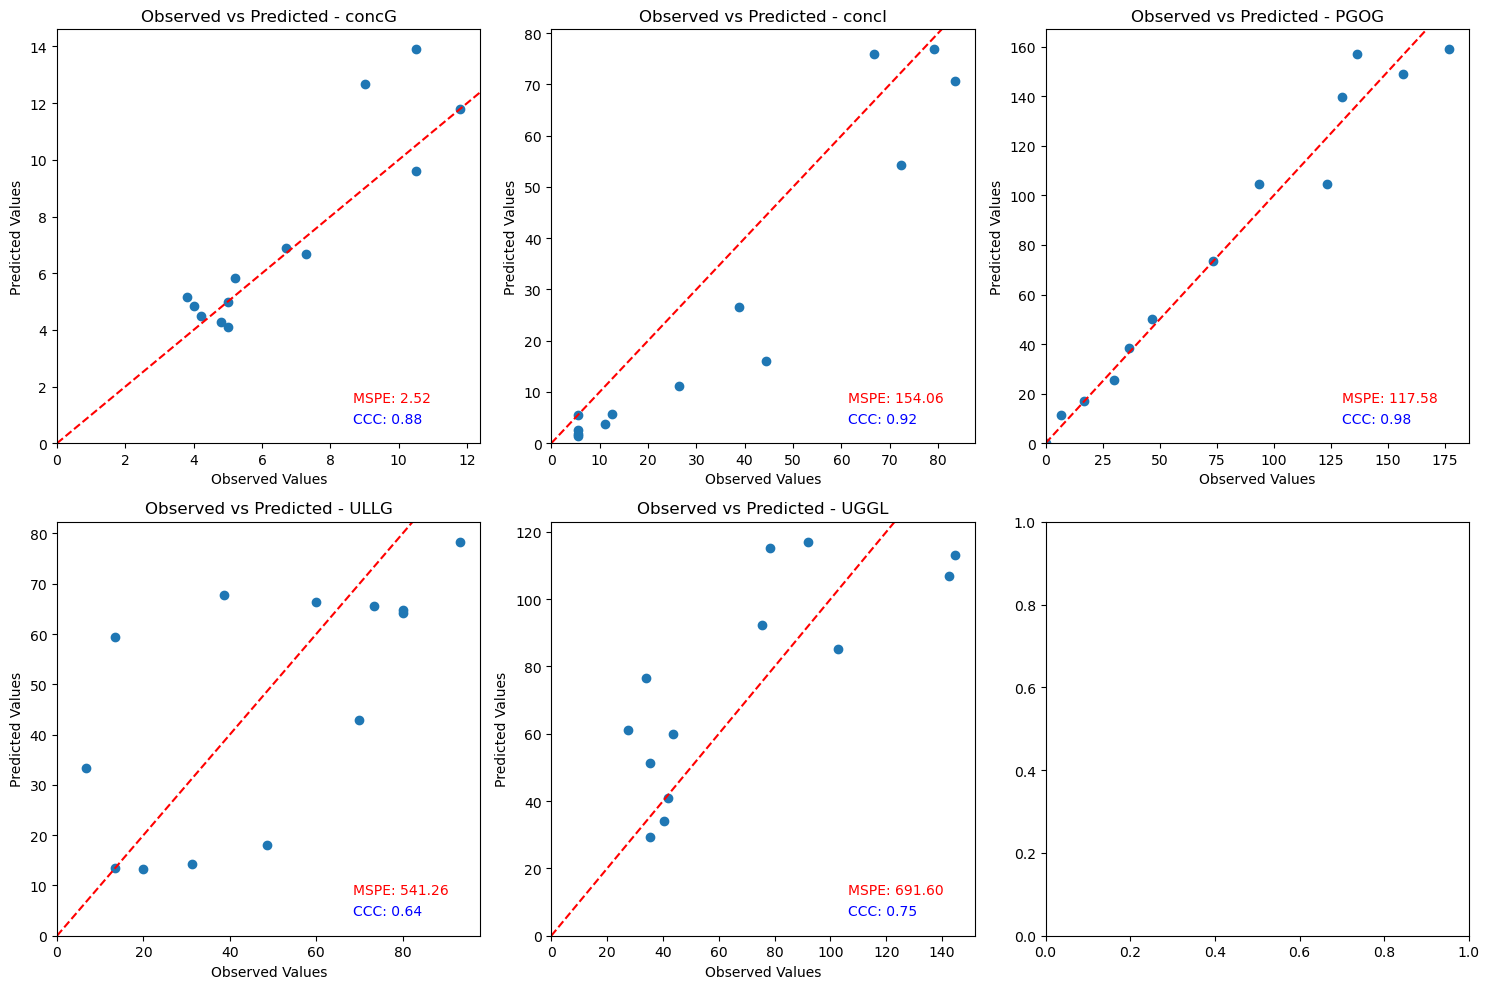

In [4]:
plot_model_output(observations, 
                  results)